# Data and Dependencies Preparations 

In [ ]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
!pip install pytorch-lightning
!pip install albumentations
!pip install torchvision       

In [ ]:
!wget https://media.istockphoto.com/videos/aerial-view-forest-fire-busuanga-palawan-philippines-video-id684083112?s=640x640
!mv ./aerial-view-forest-fire-busuanga-palawan-philippines-video-id684083112?s=640x640 foto.jpg

!wget https://c1.wallpaperflare.com/preview/721/725/166/drone-view-aerial-view-sea-ocean.jpg
!mv drone-view-aerial-view-sea-ocean.jpg laut.jpg

!wget https://media.istockphoto.com/videos/4k-aerial-view-and-zoom-out-of-forest-fire-in-sunset-time-video-id932420522?s=640x640
!mv 4k-aerial-view-and-zoom-out-of-forest-fire-in-sunset-time-video-id932420522?s=640x640 api2.jpg    

In [ ]:
import gdown

# https://drive.google.com/file/d/1-6Bg4PgGGaU5MIOPGVe-fzXIMg1yVKxv/view?usp=sharing

url='https://drive.google.com/uc?id=1-6Bg4PgGGaU5MIOPGVe-fzXIMg1yVKxv'
output_file_train='Segmentation.zip'

gdown.download(url, output_file_train, quiet=False)
!unzip Segmentation.zip

In [4]:
import torch
import torch.utils.data
import albumentations as A
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2
import os

#mode split
class DatasetLoader(torch.utils.data.Dataset):
  def __init__(self,dataset_path: str,mode:str,img_size: int):
    self.dataset_path=dataset_path
    self.mode=mode
    self.img_size=img_size

    self.imgs = list(sorted(os.listdir(os.path.join(self.dataset_path,self.mode, "Images"))))
    self.masks = list(sorted(os.listdir(os.path.join(self.dataset_path, "Masks")))) 
    self.img_size=img_size
  
  def __getitem__(self, idx):

    mask_path=self.imgs[idx].replace('.jpg','.png')
    img_path = os.path.join(self.dataset_path,self.mode,'Images', self.imgs[idx])

    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # I am still wondering why OpenCV changed to BGR by default
    
    mask_path = os.path.join(self.dataset_path,'Masks', mask_path)
    mask=cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    
    if self.mode=='train':
      heavy_transforms = [
                      A.Resize(self.img_size, self.img_size, interpolation=cv2.INTER_LINEAR, p=1), 
                      A.RandomRotate90(),
                      A.Flip(),
                      A.Transpose(),
                      A.GaussNoise(),
                      A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.7),                    
                      A.OneOf([
                          A.MotionBlur(p=0.2),
                          A.MedianBlur(blur_limit=3, p=0.1),
                          A.Blur(blur_limit=3, p=0.1),
                      ], p=0.5),                    
                      A.OneOf([                        
                          A.IAASharpen(),
                          A.IAAEmboss(),
                          A.RandomBrightnessContrast(),
                      ], p=0.5),
                      A.HueSaturationValue(p=0.3),
                      A.Normalize(
                              mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225],
                          ),
                      ToTensorV2()
                      ]                 
      aug= A.Compose(heavy_transforms ,p=1)                       
      augmented = aug(image=image, mask=mask)
      image,mask= augmented['image'],augmented['mask']
      
    else:
        heavy_transforms = [
                      A.Resize(self.img_size, self.img_size, interpolation=cv2.INTER_LINEAR, p=1), 
                      A.Normalize(
                              mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225],
                          ),
                      ToTensorV2()
                      ]                 
        aug= A.Compose(heavy_transforms ,p=1)                       
        augmented = aug(image=image, mask=mask)    
        image,mask= augmented['image'],augmented['mask']   
    
    if mask.ndim!=4:
      mask=torch.unsqueeze(mask, dim=0)
      
    mask=mask/torch.max(mask)
    mask=torch.tensor(mask, dtype=torch.uint8)
    sample = dict(image=image, mask=mask)

    return sample

  def __len__(self):
    return len(self.imgs)    

   

In [5]:
#mODE SPLIT
from torch.utils.data import DataLoader
import torch.utils.data as data


train_set=DatasetLoader('/content/Segmentation_splited/','train',224)
valid_set=DatasetLoader('/content/Segmentation_splited/','val',224)
test_set=DatasetLoader('/content/Segmentation_splited/','test',224)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=False)
test_laoder = DataLoader(test_set, batch_size=64, shuffle=False)

In [6]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

class Segmentation_custom(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # for image segmentation dice loss could be the best first choice
        # self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE)

    def forward(self, image):
        # normalize image here
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4
        

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [7]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
import gdown

# https://drive.google.com/file/d/1Vog0SCV90K3Z-3IRw-aVUqTKGSNaHEhx/view?usp=sharing

url='https://drive.google.com/uc?id=1Vog0SCV90K3Z-3IRw-aVUqTKGSNaHEhx'
output_file_train='resnet_unet.ckpt'

gdown.download(url, output_file_train, quiet=False)

# https://drive.google.com/file/d/1_1g7zTV0IPce8AN3SxcMaNL2j40otoLN/view?usp=sharing
url='https://drive.google.com/uc?id=1_1g7zTV0IPce8AN3SxcMaNL2j40otoLN'
output_file_train='mobilenetv2_nontune.ckpt'

gdown.download(url, output_file_train, quiet=False)

#https://drive.google.com/file/d/1LeicojNwoQM6-eLGdu1pX4EkKXB2D7RX/view?usp=sharing
url='https://drive.google.com/uc?id=1LeicojNwoQM6-eLGdu1pX4EkKXB2D7RX'
output_file_train='mix_transfomer_unet.ckpt'

gdown.download(url, output_file_train, quiet=False)

#https://drive.google.com/file/d/1irlDBPZWBqLTjrh-IgmQ0pgrwPAMRF76/view?usp=sharing
url='https://drive.google.com/uc?id=1irlDBPZWBqLTjrh-IgmQ0pgrwPAMRF76'
output_file_train='mix_transfomer_unet_b1.ckpt'

gdown.download(url, output_file_train, quiet=False)

# Metrics Evaluation of All Model

In [14]:
model_mitb0 = Segmentation_custom.load_from_checkpoint('/content/mix_transfomer_unet.ckpt',arch="Unet", encoder_name="mit_b0", in_channels=3, out_classes=1)
model_resnet50 = Segmentation_custom.load_from_checkpoint('/content/resnet_unet.ckpt',arch="Unet", encoder_name="resnet50", in_channels=3, out_classes=1)
model_mobilenetv2 = Segmentation_custom.load_from_checkpoint('/content/mobilenetv2_nontune.ckpt',arch="Unet", encoder_name="mobilenet_v2", in_channels=3, out_classes=1)
model_mitb1 = Segmentation_custom.load_from_checkpoint('/content/mix_transfomer_unet_b1.ckpt',arch="Unet", encoder_name="mit_b1", in_channels=3, out_classes=1)



In [10]:
def begin_evaluation(model,dataset_loader):
  tp, fp, fn, tn =0,0,0,0
  for data in val_loader:
      image_eval,mask_eval=data['image'],data['mask']
      image_eval=image_eval.type(torch.cuda.FloatTensor)
      with torch.no_grad():
          model.eval()
          model.cuda()
          logits = model(image_eval)
          pr_masks = logits.sigmoid()

      print(pr_masks.size())
      tp_buff, fp_buff, fn_buff, tn_buff = smp.metrics.get_stats(pr_masks.cpu(), mask_eval, mode='binary', threshold=0.5)
      tp, fp, fn, tn =+tp_buff, fp_buff, fn_buff, tn_buff
  
  return tp, fp, fn, tn

In [11]:
# then compute metrics with required reduction (see metric docs)
tp, fp, fn, tn=begin_evaluation(model_mobilenetv2,test_set)
iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
print('\n \n')
print('metric validation Mobilenet:')
print('iou_score: ',iou_score)
print('f1_score: ',f1_score)
print('accuracy: ',accuracy)
print('recall: ',recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([64, 1, 224, 224])
torch.Size([64, 1, 224, 224])
torch.Size([64, 1, 224, 224])
torch.Size([8, 1, 224, 224])

 

metric validation Mobilenet:
iou_score:  tensor(0.7205)
f1_score:  tensor(0.8376)
accuracy:  tensor(0.9987)
recall:  tensor(0.8173)


In [12]:
# then compute metrics with required reduction (see metric docs)
tp, fp, fn, tn=begin_evaluation(model_resnet50,test_set)
iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
print('\n \n')
print('metric validation Resnet50:')
print('iou_score: ',iou_score)
print('f1_score: ',f1_score)
print('accuracy: ',accuracy)
print('recall: ',recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([64, 1, 224, 224])
torch.Size([64, 1, 224, 224])
torch.Size([64, 1, 224, 224])
torch.Size([8, 1, 224, 224])

 

metric validation Resnet50:
iou_score:  tensor(0.6968)
f1_score:  tensor(0.8213)
accuracy:  tensor(0.9986)
recall:  tensor(0.8114)


In [16]:
# then compute metrics with required reduction (see metric docs)
tp, fp, fn, tn=begin_evaluation(model_mitb0,test_set)
iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

print('\n \n')
print('metric validation Mix Vision Transformer:')
print('iou_score: ',iou_score)
print('f1_score: ',f1_score)
print('accuracy: ',accuracy)
print('recall: ',recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([64, 1, 224, 224])
torch.Size([64, 1, 224, 224])
torch.Size([64, 1, 224, 224])
torch.Size([8, 1, 224, 224])

 

metric validation Mix Vision Transformer:
iou_score:  tensor(0.6413)
f1_score:  tensor(0.7814)
accuracy:  tensor(0.9980)
recall:  tensor(0.8863)


In [17]:
# then compute metrics with required reduction (see metric docs)
tp, fp, fn, tn=begin_evaluation(model_mitb1,test_set)
iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

print('\n \n')
print('metric validation Mix Vision Transformer B1:')
print('iou_score: ',iou_score)
print('f1_score: ',f1_score)
print('accuracy: ',accuracy)
print('recall: ',recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([64, 1, 224, 224])
torch.Size([64, 1, 224, 224])
torch.Size([64, 1, 224, 224])
torch.Size([8, 1, 224, 224])

 

metric validation Mix Vision Transformer B1:
iou_score:  tensor(0.6676)
f1_score:  tensor(0.8006)
accuracy:  tensor(0.9985)
recall:  tensor(0.7846)


# Demo Result MobileNetv2

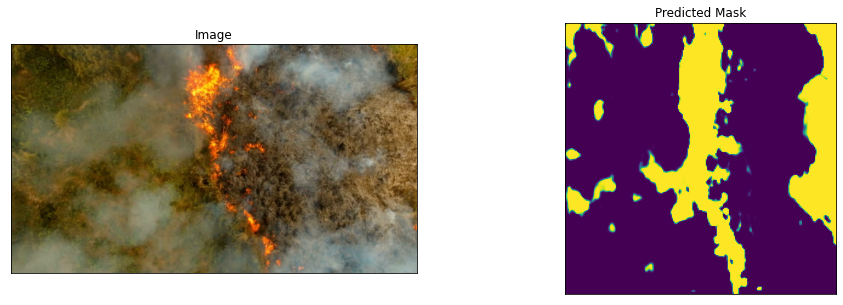

In [ ]:
image = cv2.imread('./foto.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

heavy_transforms = [
                    A.Resize(224,224, interpolation=cv2.INTER_LINEAR, p=1), 
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2()
                    ]  
aug= A.Compose(heavy_transforms ,p=1)                       
augmented = aug(image=image)

img=augmented['image']
img=img.type(torch.cuda.FloatTensor)

with torch.no_grad():
    model_mobilenetv2.eval()
    logits = model_mobilenetv2(img[None,...])
    pr_masks = logits.sigmoid()

visualize(
        image=image, 
        predicted_mask=pr_masks.squeeze().cpu()
    )

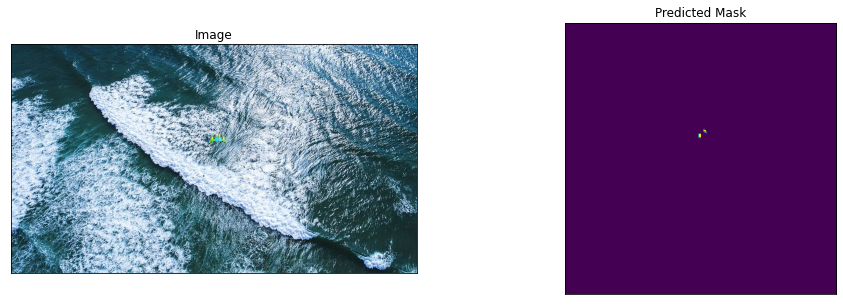

In [ ]:
image = cv2.imread('./laut.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

heavy_transforms = [
                    A.Resize(224,224, interpolation=cv2.INTER_LINEAR, p=1), 
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2()
                    ]  
aug= A.Compose(heavy_transforms ,p=1)                       
augmented = aug(image=image)

img=augmented['image']
img=img.type(torch.cuda.FloatTensor)

with torch.no_grad():
    model_mobilenetv2.eval()
    logits = model_mobilenetv2(img[None,...])
    pr_masks = logits.sigmoid()

visualize(
        image=image, 
        predicted_mask=pr_masks.squeeze().cpu()
    )

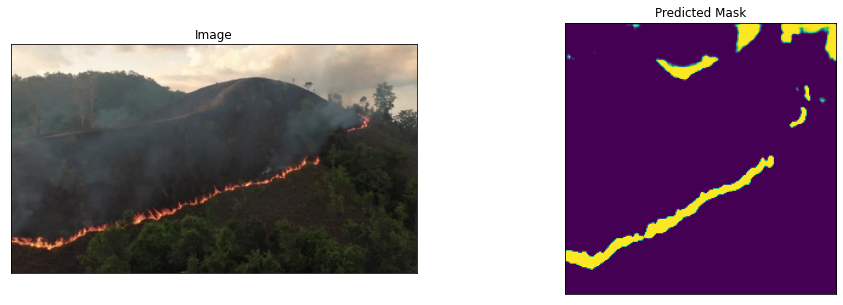

In [ ]:
image = cv2.imread('./api2.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

heavy_transforms = [
                    A.Resize(224,224, interpolation=cv2.INTER_LINEAR, p=1), 
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2()
                    ]  
aug= A.Compose(heavy_transforms ,p=1)                       
augmented = aug(image=image)

img=augmented['image']
img=img.type(torch.cuda.FloatTensor)

with torch.no_grad():
    model_mobilenetv2.eval()
    logits = model_mobilenetv2(img[None,...])
    pr_masks = logits.sigmoid()

visualize(
        image=image, 
        predicted_mask=pr_masks.squeeze().cpu()
    )

# Demo Result ResNet50

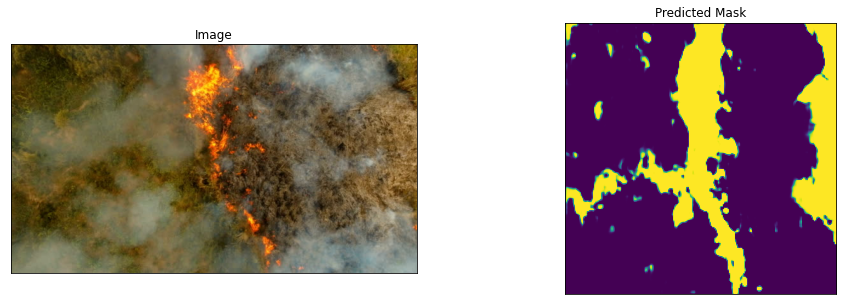

In [ ]:
image = cv2.imread('./foto.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

heavy_transforms = [
                    A.Resize(224,224, interpolation=cv2.INTER_LINEAR, p=1), 
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2()
                    ]  
aug= A.Compose(heavy_transforms ,p=1)                       
augmented = aug(image=image)

img=augmented['image']
img=img.type(torch.cuda.FloatTensor)

with torch.no_grad():
    model_resnet50.eval()
    logits = model_resnet50(img[None,...])
    pr_masks = logits.sigmoid()

visualize(
        image=image, 
        predicted_mask=pr_masks.squeeze().cpu()
    )

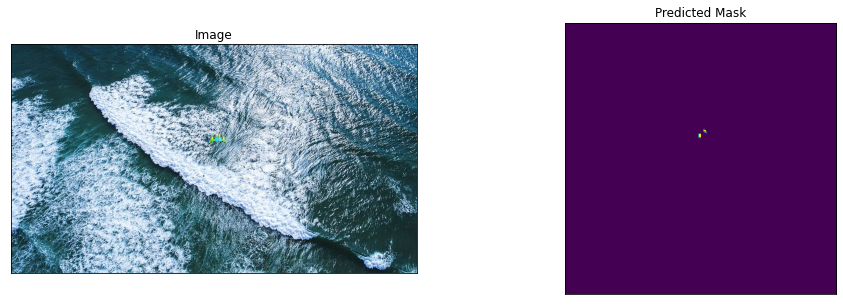

In [ ]:
image = cv2.imread('./laut.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

heavy_transforms = [
                    A.Resize(224,224, interpolation=cv2.INTER_LINEAR, p=1), 
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2()
                    ]  
aug= A.Compose(heavy_transforms ,p=1)                       
augmented = aug(image=image)

img=augmented['image']
img=img.type(torch.cuda.FloatTensor)

with torch.no_grad():
    model_mobilenetv2.eval()
    logits = model_mobilenetv2(img[None,...])
    pr_masks = logits.sigmoid()

visualize(
        image=image, 
        predicted_mask=pr_masks.squeeze().cpu()
    )

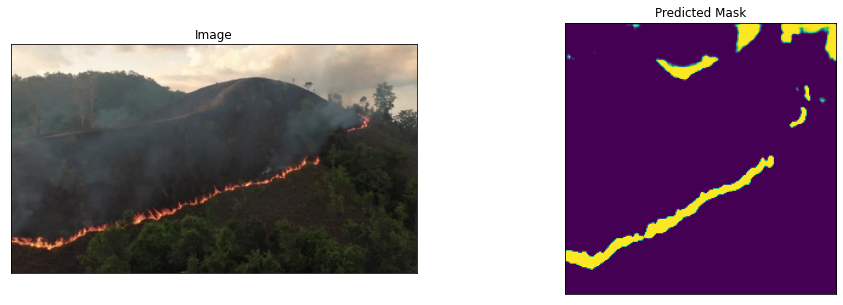

In [ ]:
image = cv2.imread('./api2.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

heavy_transforms = [
                    A.Resize(224,224, interpolation=cv2.INTER_LINEAR, p=1), 
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2()
                    ]  
aug= A.Compose(heavy_transforms ,p=1)                       
augmented = aug(image=image)

img=augmented['image']
img=img.type(torch.cuda.FloatTensor)

with torch.no_grad():
    model_mobilenetv2.eval()
    logits = model_mobilenetv2(img[None,...])
    pr_masks = logits.sigmoid()

visualize(
        image=image, 
        predicted_mask=pr_masks.squeeze().cpu()
    )

# Demo Result Mix Transformer baseline 0

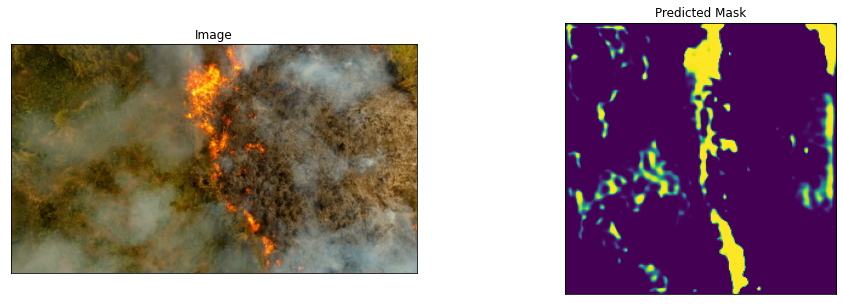

In [ ]:
image = cv2.imread('./foto.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

heavy_transforms = [
                    A.Resize(224,224, interpolation=cv2.INTER_LINEAR, p=1), 
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2()
                    ]  
aug= A.Compose(heavy_transforms ,p=1)                       
augmented = aug(image=image)

img=augmented['image']
img=img.type(torch.cuda.FloatTensor)

with torch.no_grad():
    model_mitb0.eval()
    logits = model_mitb0(img[None,...])
    pr_masks = logits.sigmoid()

visualize(
        image=image, 
        predicted_mask=pr_masks.squeeze().cpu()
    )

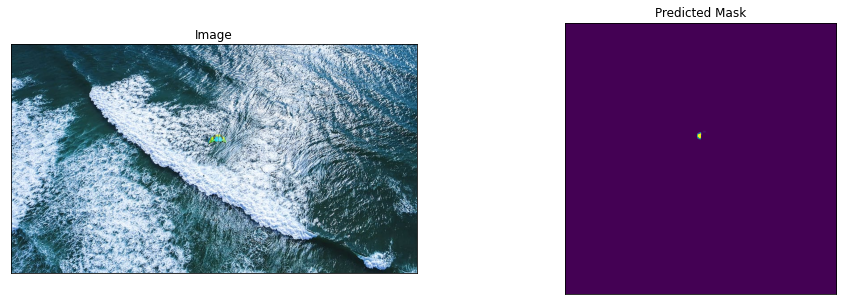

In [ ]:
image = cv2.imread('./laut.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

heavy_transforms = [
                    A.Resize(224,224, interpolation=cv2.INTER_LINEAR, p=1), 
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2()
                    ]  
aug= A.Compose(heavy_transforms ,p=1)                       
augmented = aug(image=image)

img=augmented['image']
img=img.type(torch.cuda.FloatTensor)

with torch.no_grad():
    model_mitb0.eval()
    logits = model_mitb0(img[None,...])
    pr_masks = logits.sigmoid()

visualize(
        image=image, 
        predicted_mask=pr_masks.squeeze().cpu()
    )

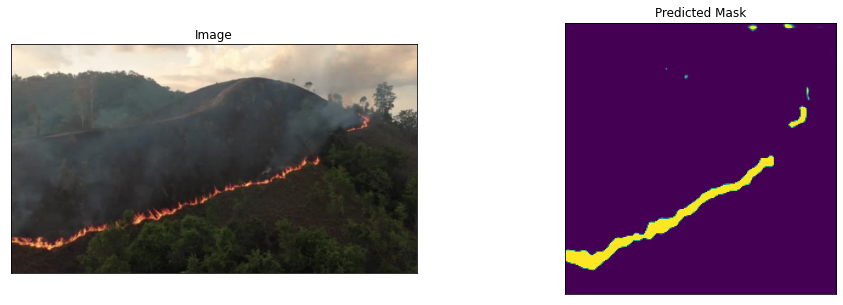

In [ ]:
image = cv2.imread('./api2.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

heavy_transforms = [
                    A.Resize(224,224, interpolation=cv2.INTER_LINEAR, p=1), 
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2()
                    ]  
aug= A.Compose(heavy_transforms ,p=1)                       
augmented = aug(image=image)

img=augmented['image']
img=img.type(torch.cuda.FloatTensor)

with torch.no_grad():
    model_mitb0.eval()
    logits = model_mitb0(img[None,...])
    pr_masks = logits.sigmoid()

visualize(
        image=image, 
        predicted_mask=pr_masks.squeeze().cpu()
    )

# Demo Result MixTransformer Baseline 2

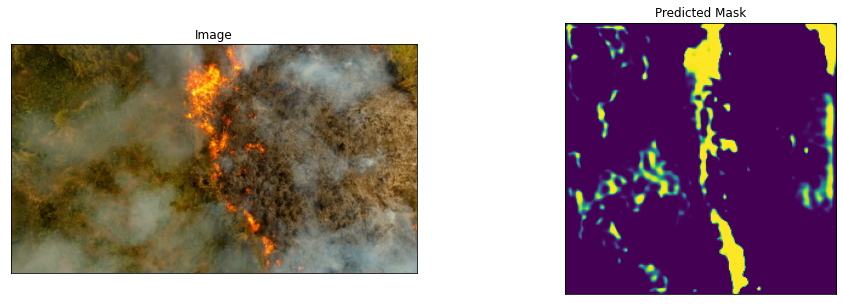

In [18]:
image = cv2.imread('./foto.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

heavy_transforms = [
                    A.Resize(224,224, interpolation=cv2.INTER_LINEAR, p=1), 
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2()
                    ]  
aug= A.Compose(heavy_transforms ,p=1)                       
augmented = aug(image=image)

img=augmented['image']
img=img.type(torch.cuda.FloatTensor)

with torch.no_grad():
    model_mitb1.eval()
    logits = model_mitb0(img[None,...])
    pr_masks = logits.sigmoid()

visualize(
        image=image, 
        predicted_mask=pr_masks.squeeze().cpu()
    )

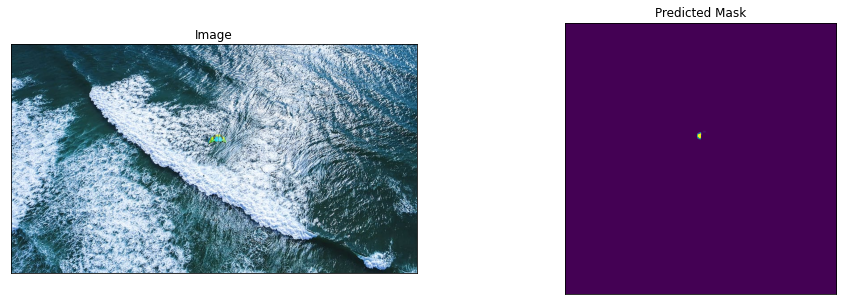

In [19]:
image = cv2.imread('./laut.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

heavy_transforms = [
                    A.Resize(224,224, interpolation=cv2.INTER_LINEAR, p=1), 
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2()
                    ]  
aug= A.Compose(heavy_transforms ,p=1)                       
augmented = aug(image=image)

img=augmented['image']
img=img.type(torch.cuda.FloatTensor)

with torch.no_grad():
    model_mitb1.eval()
    logits = model_mitb0(img[None,...])
    pr_masks = logits.sigmoid()

visualize(
        image=image, 
        predicted_mask=pr_masks.squeeze().cpu()
    )

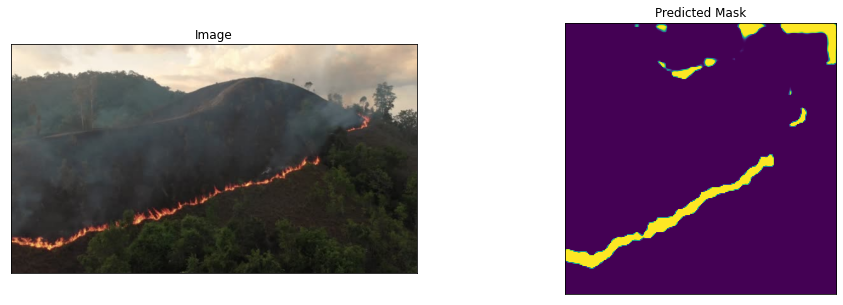

In [21]:
image = cv2.imread('./api2.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

heavy_transforms = [
                    A.Resize(224,224, interpolation=cv2.INTER_LINEAR, p=1), 
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2()
                    ]  
aug= A.Compose(heavy_transforms ,p=1)                       
augmented = aug(image=image)

img=augmented['image']
img=img.type(torch.cuda.FloatTensor)

with torch.no_grad():
    model_mitb1.eval()
    logits = model_mitb1(img[None,...])
    pr_masks = logits.sigmoid()

visualize(
        image=image, 
        predicted_mask=pr_masks.squeeze().cpu()
    )